In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/national-basketball-association-nba/nba-players.csv


**Overview**

The data consists of performance statistics from NBA players. There are 1,341 observations, and each observation in the data represents a different player in the NBA. The target variable is a Boolean value that indicates whether a given player will last in the league for five years.

A firm that provides insights for management and coaches in the National Basketball Association (NBA) is interested in retaining players who can last in the high-pressure environment of professional basketball and help the team be successful over time. 

**Business Proposal**

The goal is to help NBA managers identify which players are most likely to thrive in such a competitive enviroment like the NBA. To do this succesfully, I will analyze the dataset of NBA players and their performance records, conduct feature engineering to determine which features will most effectively predict whether a player’s NBA career will last at least five years, and then use those insights to fit several supervised learning models to this binary classification problem.

In [2]:
# Import necessary libraries and pacakages
import pandas as pd
import numpy as np
from sklearn import naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis  # Added LDA and QDA
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt

In [3]:
# Load in the dataset
nba= pd.read_csv('/kaggle/input/national-basketball-association-nba/nba-players.csv')

In [4]:
# View data
nba.head(10)

,Unnamed: 0,name,gp,min,pts,fgm,fga,fg,3p_made,3pa,...,fta,ft,oreb,dreb,reb,ast,stl,blk,tov,target_5yrs
0,0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0
2,2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0
3,3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1
4,4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1
5,5,Tony Bennett,75,11.4,3.7,1.5,3.5,42.3,0.3,1.1,...,0.5,73.2,0.2,0.7,0.8,1.8,0.4,0.0,0.7,0
6,6,Don MacLean,62,10.9,6.6,2.5,5.8,43.5,0.0,0.1,...,1.8,81.1,0.5,1.4,2.0,0.6,0.2,0.1,0.7,1
7,7,Tracy Murray,48,10.3,5.7,2.3,5.4,41.5,0.4,1.5,...,0.8,87.5,0.8,0.9,1.7,0.2,0.2,0.1,0.7,1
8,8,Duane Cooper,65,9.9,2.4,1.0,2.4,39.2,0.1,0.5,...,0.5,71.4,0.2,0.6,0.8,2.3,0.3,0.0,1.1,0
9,9,Dave Johnson,42,8.5,3.7,1.4,3.5,38.3,0.1,0.3,...,1.4,67.8,0.4,0.7,1.1,0.3,0.2,0.0,0.7,0


In [5]:
# View shape
nba.shape

(1340, 22)

In [6]:
# Check for missing values
nba.isnull().sum()

Unnamed: 0     0
name           0
gp             0
min            0
pts            0
fgm            0
fga            0
fg             0
3p_made        0
3pa            0
3p             0
ftm            0
fta            0
ft             0
oreb           0
dreb           0
reb            0
ast            0
stl            0
blk            0
tov            0
target_5yrs    0
dtype: int64

In [7]:
# Class balance
nba['target_5yrs'].value_counts(normalize= True) * 100

target_5yrs
1    62.014925
0    37.985075
Name: proportion, dtype: float64

**Class Balance**

About 62% of the values in the target column belong to class 1, and about 38% of the values
belong to class 0. In other words, about 62% of players represented by this data have an NBA career duration of at least five years, and about 38% do not.

The dataset is not perfectly balanced, but an exact 50-50 split is a rare occurance in datasets, and a 62-38 split is not too imbalanced. However, if the majority class made up 90% or more of thedataset, then that would be of concern, and it would be prudent to address that issue through techniques like upsampling and downsampling.

**Column Selection** 

The goal here is to identify features that will serve as useful predictors to the target variable.

The name column should be avoided as a feature. A player’s name is not helpful in determining their career duration. 

The number of games a player has played in may not be as important in determining their career duration as the number of points they have earned. While you could say that someone who has played in more games may have more practice and experience, the points they earn during the games they played in would speak more to their performance as a player. This, in turn, would influence their career duration. So, the 'gp' column on its own may not be a helpful feature. 
However, 'games played' and 'points' could be combined to get the total number of points earned across the games played, and that result could be a helpful feature.

If the number of points earned across games will be extracted as a feature, then that could be combined with the number of minutes played across games (min * gp) to extract another feature. This could be a measure of players’ efficiency and could help in predicting players’ career duration.

'minutes' on its own may not be useful as a feature for the same reason as 'games played'.

There are three different columns that give information about field goals. The percent of field goals a player makes (fg) says more about their performance than the number of field goals they make (fgm) or the number of field goals they attempt (fga). The percent gives more context, as it takes into account both how many field goals a player successfully made and how many field goals they attempted in total. This allows for a more meaningful comparison between players. The same logic applies to the percent of three-point field goals made, as well as the percent of free throws made.

There are columns for the number offensive rebounds (oreb), the number of defensive rebounds (dreb), and the number of rebounds overall (reb). Because the overall number of rebounds should already incorporate both offensive and defensive rebounds, it would make sense to use the overall as a feature.

The number of assists (ast), steals (stl), blocks (blk), and turnovers (tov) also provide information about how well players are performing in games, and thus, could be helpful in predicting how longplayers last in the league.

In [8]:
# Column selection
nba_data= nba[['gp', 'min', 'pts', 'fg', '3p', 'ft', 'reb', 'ast', 'stl', 'blk', 'tov', 'target_5yrs']]
nba_data.head(10)

,gp,min,pts,fg,3p,ft,reb,ast,stl,blk,tov,target_5yrs
0,36,27.4,7.4,34.7,25.0,69.9,4.1,1.9,0.4,0.4,1.3,0
1,35,26.9,7.2,29.6,23.5,76.5,2.4,3.7,1.1,0.5,1.6,0
2,74,15.3,5.2,42.2,24.4,67.0,2.2,1.0,0.5,0.3,1.0,0
3,58,11.6,5.7,42.6,22.6,68.9,1.9,0.8,0.6,0.1,1.0,1
4,48,11.5,4.5,52.4,0.0,67.4,2.5,0.3,0.3,0.4,0.8,1
5,75,11.4,3.7,42.3,32.5,73.2,0.8,1.8,0.4,0.0,0.7,0
6,62,10.9,6.6,43.5,50.0,81.1,2.0,0.6,0.2,0.1,0.7,1
7,48,10.3,5.7,41.5,30.0,87.5,1.7,0.2,0.2,0.1,0.7,1
8,65,9.9,2.4,39.2,23.3,71.4,0.8,2.3,0.3,0.0,1.1,0
9,42,8.5,3.7,38.3,21.4,67.8,1.1,0.3,0.2,0.0,0.7,0


**Feature Extraction**

The 'gp', 'pts' and 'min' columns lend themselves to feature extraction. 'gp' represents the total number of games a player has played in, and 'pts' represents the average number of points the player has earned per game. It might be helpful to combine these columns to get the total number of points the player has earned across the games and use the result as a new feature, which could be added to a new column named 'total_points'. The total points earned by a player can reflect their performance and shape their career longevity.

The 'min' column represents the average number of minutes played per game. 'total_points' could be combined with 'min' and 'gp' to extract a new feature: points earned per minute. This can be considered a measure of player efficiency, which could shape career duration. This feature can be added into a column named 'efficiency'. 

In [9]:
# Extract features to help predict target variable
ex_nba= nba_data.copy()

ex_nba['total_points']= ex_nba['gp'] * ex_nba['pts']

ex_nba['efficiency']= ex_nba['total_points'] / (ex_nba['min'] * ex_nba['gp'])
ex_nba= ex_nba.drop(columns= ['gp', 'pts', 'min'])
ex_nba.head(10)

,fg,3p,ft,reb,ast,stl,blk,tov,target_5yrs,total_points,efficiency
0,34.7,25.0,69.9,4.1,1.9,0.4,0.4,1.3,0,266.4,0.270073
1,29.6,23.5,76.5,2.4,3.7,1.1,0.5,1.6,0,252.0,0.267658
2,42.2,24.4,67.0,2.2,1.0,0.5,0.3,1.0,0,384.8,0.339869
3,42.6,22.6,68.9,1.9,0.8,0.6,0.1,1.0,1,330.6,0.491379
4,52.4,0.0,67.4,2.5,0.3,0.3,0.4,0.8,1,216.0,0.391304
5,42.3,32.5,73.2,0.8,1.8,0.4,0.0,0.7,0,277.5,0.324561
6,43.5,50.0,81.1,2.0,0.6,0.2,0.1,0.7,1,409.2,0.605505
7,41.5,30.0,87.5,1.7,0.2,0.2,0.1,0.7,1,273.6,0.553398
8,39.2,23.3,71.4,0.8,2.3,0.3,0.0,1.1,0,156.0,0.242424
9,38.3,21.4,67.8,1.1,0.3,0.2,0.0,0.7,0,155.4,0.435294


In [10]:
# Define variables for Naive Bayes model
y= ex_nba['target_5yrs']
X= ex_nba.copy()
X= X.drop('target_5yrs', axis=1)

In [11]:
# Split train and test data
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.3, random_state= 42)

In [12]:
# Choose which models to fit
models = {
    'Logistic Regression': LogisticRegression(solver = "newton-cholesky", max_iter=500),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=37),
    'Linear SVM' : SVC(kernel="linear", C=0.001, random_state=37, probability=True),
    'Naive Bayes' : naive_bayes.MultinomialNB(),
    'k-NN': KNeighborsClassifier(10),
    'LDA': LinearDiscriminantAnalysis(),
    'Neural Network': MLPClassifier(activation="logistic", max_iter=5000, random_state=37),
    'zero_rule' : DummyClassifier(strategy="most_frequent")
}
plt.figure()


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>


Model: Logistic Regression
Number of mislabeled points out of a total 402 points : 122
F1 Score: 0.769811320754717
Training Accuracy: 0.7057569296375267
Testing Accuracy: 0.6965174129353234
Cross-validation scores: [0.67910448 0.70522388 0.75746269 0.66044776 0.67537313]
Average cross-validation score: 0.6955223880597015

Model: Decision Tree
Number of mislabeled points out of a total 402 points : 174
F1 Score: 0.6561264822134387
Training Accuracy: 0.9861407249466951
Testing Accuracy: 0.5671641791044776
Cross-validation scores: [0.6119403  0.62313433 0.6119403  0.58208955 0.62313433]
Average cross-validation score: 0.6104477611940299

Model: Random Forest
Number of mislabeled points out of a total 402 points : 127
F1 Score: 0.7669724770642202
Training Accuracy: 0.7505330490405118
Testing Accuracy: 0.6840796019900498
Cross-validation scores: [0.70149254 0.69776119 0.69402985 0.66791045 0.67164179]
Average cross-validation score: 0.6865671641791045

Model: Linear SVM
Number of mislabele

<function matplotlib.pyplot.show(close=None, block=None)>

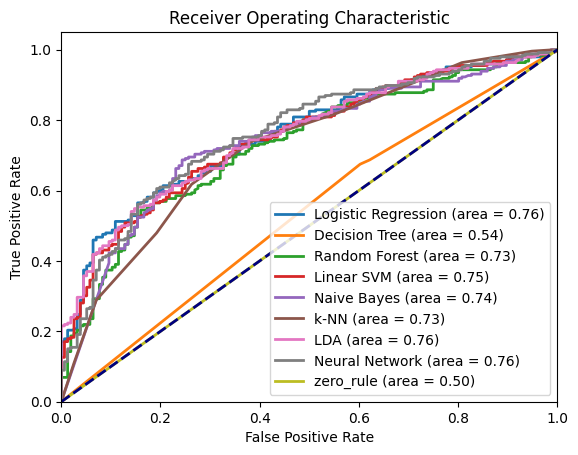

In [13]:
# Fit all the model and calculate evaluation metrics using a for-loop
for name, model in models.items():
    model.fit(X_train, y_train)
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (area = {roc_auc:.2f})')
    y_pred = model.predict(X_test)
    print(f"\nModel: {name}")
    print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
    print("F1 Score:" ,f1_score(y_test, y_pred))
    train_accuracy = model.score(X_train, y_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
    print("Cross-validation scores:", scores)
    print("Average cross-validation score:", scores.mean())
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show

**Model Scores**
* Metrics tested: Training and testing accuracy, F1-Score, ROC curve
* All models are compared against a Zero-rule dummy model which randomly samples classes according to their proportions in the training data. This gives a F1 score of 0.7592 and AUC of 0.5.
* Models with an F1 score better than the Zero-rule model are Logistic Regression (0.7698), SVM (0.7633), LDA (0.7638) and Multilayer Perceptron (0.7843).
* Decision Tree shows significant overfitting, as is evident from its much higher training vs testing accuracy. Random Forest initially also showed this but was fixed by tuning the hyperparameters.
* Linear kernel based SVM works better than other kernels. 
* Logistic Regression, LDA and Multilayer Perceptron have the highest area the ROC curve.
* Overall, Logistic Regression (with the "newton-cholesky" solver) and the Multilayer Perceptron show the most promising results, although LDA and SVM are also not much worse.

**Conclusion**
In conclusion, linear models like Linear SVM, Linear Discriminant Analysis and Logistic Regression perform pretty good. This shows that the data is linearly or nearly-linearly separable. Even though Multilayer Perceptron performs slightly better than other models, its additional complexity might not be needed since it is more suitable to fit non-linear relationships between the features and target variable. 